**Face Recognition Using Eigenface**

**Student's ID: 188163**

**Student's name: Dang Xuan Tien**

# Import Library

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import time

# Define Function

**Plot function using matplotlib**

In [0]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)



---


**Define a PCA function**

In [0]:
def pca(X, n_components = 0):
   # Get average face of data set
    mu = X.mean(axis = 1).reshape(-1, 1)
    
    # Get the deviation of each image from mean image
    Dev = X - mu
    
    # Get Covariance
    Cov = np.dot(Dev, Dev.T)
    Cov = Cov/Dev.shape[1]
#     x_adjusted = X - mu
    
#     Cov = np.cov(x_adjusted, rowvar=True)
    
    #Get Eigenvalues and Eigenvectors
    [eigenvalues, eigenvectors] = np.linalg.eig(Cov)
    
    # Sort eigenvectors descending by their eigenvalue
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    
    # Select only n_components
    eigenvalues = eigenvalues[0:n_components]
    eigenvectors = eigenvectors[:, 0:n_components]
    
    return [eigenvalues, eigenvectors, mu]

**Caculate the Projection**

In [0]:
def project(EVts, X, mu):
    return np.dot(EVts.T, X - mu)

**Predict function**

In [0]:
def Eigenface_predict(test_data, EVts, mu, prj, y_train):
    test_data_copy = test_data
    f_s = project(EVts, test_data_copy, mu)
    
    idx = np.arange(test_data_copy.shape[1])
    y_pred = np.zeros((test_data_copy.shape[1]), dtype = np.int32) - 1
    # Caculate the Euclidian distance
    for ix in idx:
        diff = f_s[:, ix].reshape(-1, 1)
        D = np.linalg.norm(diff - prj, axis = 0)
        y_pred[ix] = y_train[np.argmin(D)]
    return y_pred

**Others**

In [0]:
def reconstruct(X, EVts, mu):
    EVts = EVts.T
    return np.dot(X, EVts) + mu

def normalize(X, low = 0, high = 255):
    X = np.asarray(X)
    minX, maxX = np.min(X), np.max(X)
    #Normalize to [0, 1]
    X = X - float(minX)
    X = X / float((maxX - minX))
    #Normalize to [low, high]
    X = X * (high - low)
    X = X + low
    return np.asarray(X)

# Load Data

Using dataset [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (LFW)

In [72]:
# Download data
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# Normalize data to [0 1]
X = X/255.0

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features = h x w = %d x %d = %d" % (h, w, n_features))


# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.T
X_test = X_test.T

# X_test_plot = np.uint8(255.0*X_test.T)
# plot_gallery(X_test_plot, prediction_titles, h, w)


print("========================================================================")
print("Training set size:")
print(X_train.shape)

print("Testing set size:")
print(X_test.shape)


Total dataset size:
n_samples: 1288
n_classes: 7
n_features = h x w = 50 x 37 = 1850
Training set size:
(1850, 901)
Testing set size:
(1850, 387)


# Runing Eigenface

In [76]:
n_components = 150
        
[eigenvalues, eigenvectors, mu] = pca(X_train, n_components = int(n_components))

#print(eigenvectors.shape)
#print(mu.shape)
f_s = project(eigenvectors, X_train, mu)
y_pred = Eigenface_predict(X_test, eigenvectors, mu, f_s, y_train)

print('n_components = ', n_components)    
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

n_components =  150
Accuracy score:  0.5348837209302325
                   precision    recall  f1-score   support

     Ariel Sharon      0.333     0.333     0.333        18
     Colin Powell      0.477     0.449     0.463        69
  Donald Rumsfeld      0.370     0.500     0.425        34
    George W Bush      0.691     0.687     0.689       166
Gerhard Schroeder      0.357     0.323     0.339        31
      Hugo Chavez      0.429     0.474     0.450        19
       Tony Blair      0.455     0.400     0.426        50

      avg / total      0.538     0.535     0.535       387



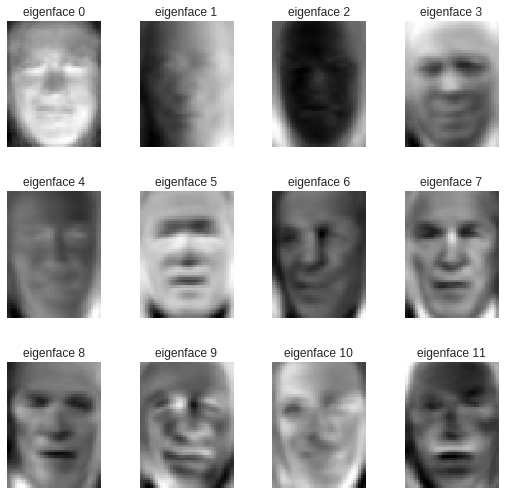

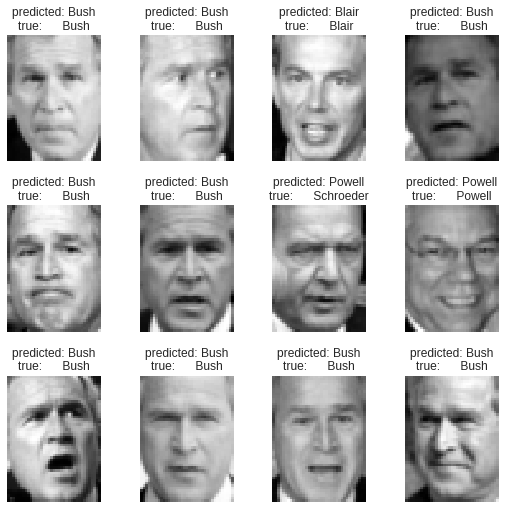

In [77]:
eigenfaces = np.real(np.reshape(eigenvectors.T, (n_components, h, w)))

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

# Plot some example of predict result
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

X_test_plot = np.uint8(255.0*X_test.T)
plot_gallery(X_test_plot, prediction_titles, h, w)
# print(X_test_plot.min())
# print(X_test_plot.max())
